In [1]:
import pickle
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *



In [2]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1




In [9]:
from scipy.linalg import cho_factor, cho_solve

def compute_fisher_at_param_only_As_omc(nu_mass_ev):
    cov_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/fiducial_cluster_abundance_covariance_nu_mass_%.4f.pkl'%(nu_mass_ev)
    with open(cov_fname, 'rb') as file:
#         print(cov_fname)
        cluster_count_cov = pickle.load(file) 
    cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

    for i in range(n_z):
        for j in range(n_z):
            for a in range(n_r):
                for b in range(n_r):
                    row_index = i * n_r + a
                    col_index = j * n_r + b
                    cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]

                
                
    cholesky_factor = cho_factor(cov_matrix_2d)
    cov_inv = cho_solve(cholesky_factor, np.eye(n_z * n_r))                

    dμdθ = {}
    dμdθ_unflat = {}

    for parameter_changed in ['10^9 As', 'omch2']:
        cluster_abundance_pos = None
        cluster_abundance_neg = None
        log10_rel_step_size = fiducial_log10_rel_step_size[parameter_changed]
        fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.4f_nu_mass_ev_%.4f'%(parameter_changed, log10_rel_step_size, nu_mass_ev)
#         print(fname_base)
        with open(fname_base, 'rb') as file:
            cluster_abundance_pos = pickle.load(file)
        with open(fname_base+'_neg', 'rb') as file:
            cluster_abundance_neg = pickle.load(file)
        h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
        tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
        flattened_theory_deriv = np.zeros((n_z * n_r))
        for i in range(n_z):
            for a in range(n_r):
                flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
        dμdθ[parameter_changed] = flattened_theory_deriv
        dμdθ_unflat[parameter_changed] = tmp_theory_deriv
    n_parameters = 2

    fisher_matrix = np.zeros((n_parameters, n_parameters))

    for i, θi in enumerate(['10^9 As', 'omch2']):
#         print(i, θi)
        if(θi == 'nu_mass_ev'):
            nu_mass_ev_idx = i
        for j, θj in enumerate(['10^9 As', 'omch2']):
            dμl_θi = dμdθ[θi]
            dμm_θj = dμdθ[θj]
            fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)
    return fisher_matrix

In [10]:
compute_fisher_at_param_only_As_omc(0.06)

array([[   98881.04414906,  2847271.09773311],
       [ 2847271.09773311, 82525453.34401776]])

In [26]:
from tqdm import tqdm
fisher_matrixes = {}
nu_masses = np.arange(0.06, .297, 0.01)
del_idxs = []
for i,nu_mass in tqdm(enumerate(np.arange(0.06, .297, 0.01))):
    try:
        fisher_matrixes[nu_mass] = compute_fisher_at_param_only_As_omc(nu_mass)
    except:
        print('skipping', nu_mass)
        del_idxs += [i]


24it [00:00, 477.34it/s]


In [27]:
print(len(nu_masses))
for del_idx in reversed(del_idxs):
    nu_masses = np.delete(nu_masses, (del_idx))
print(len(nu_masses))

24
24


In [28]:
plt.show()
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'serif'


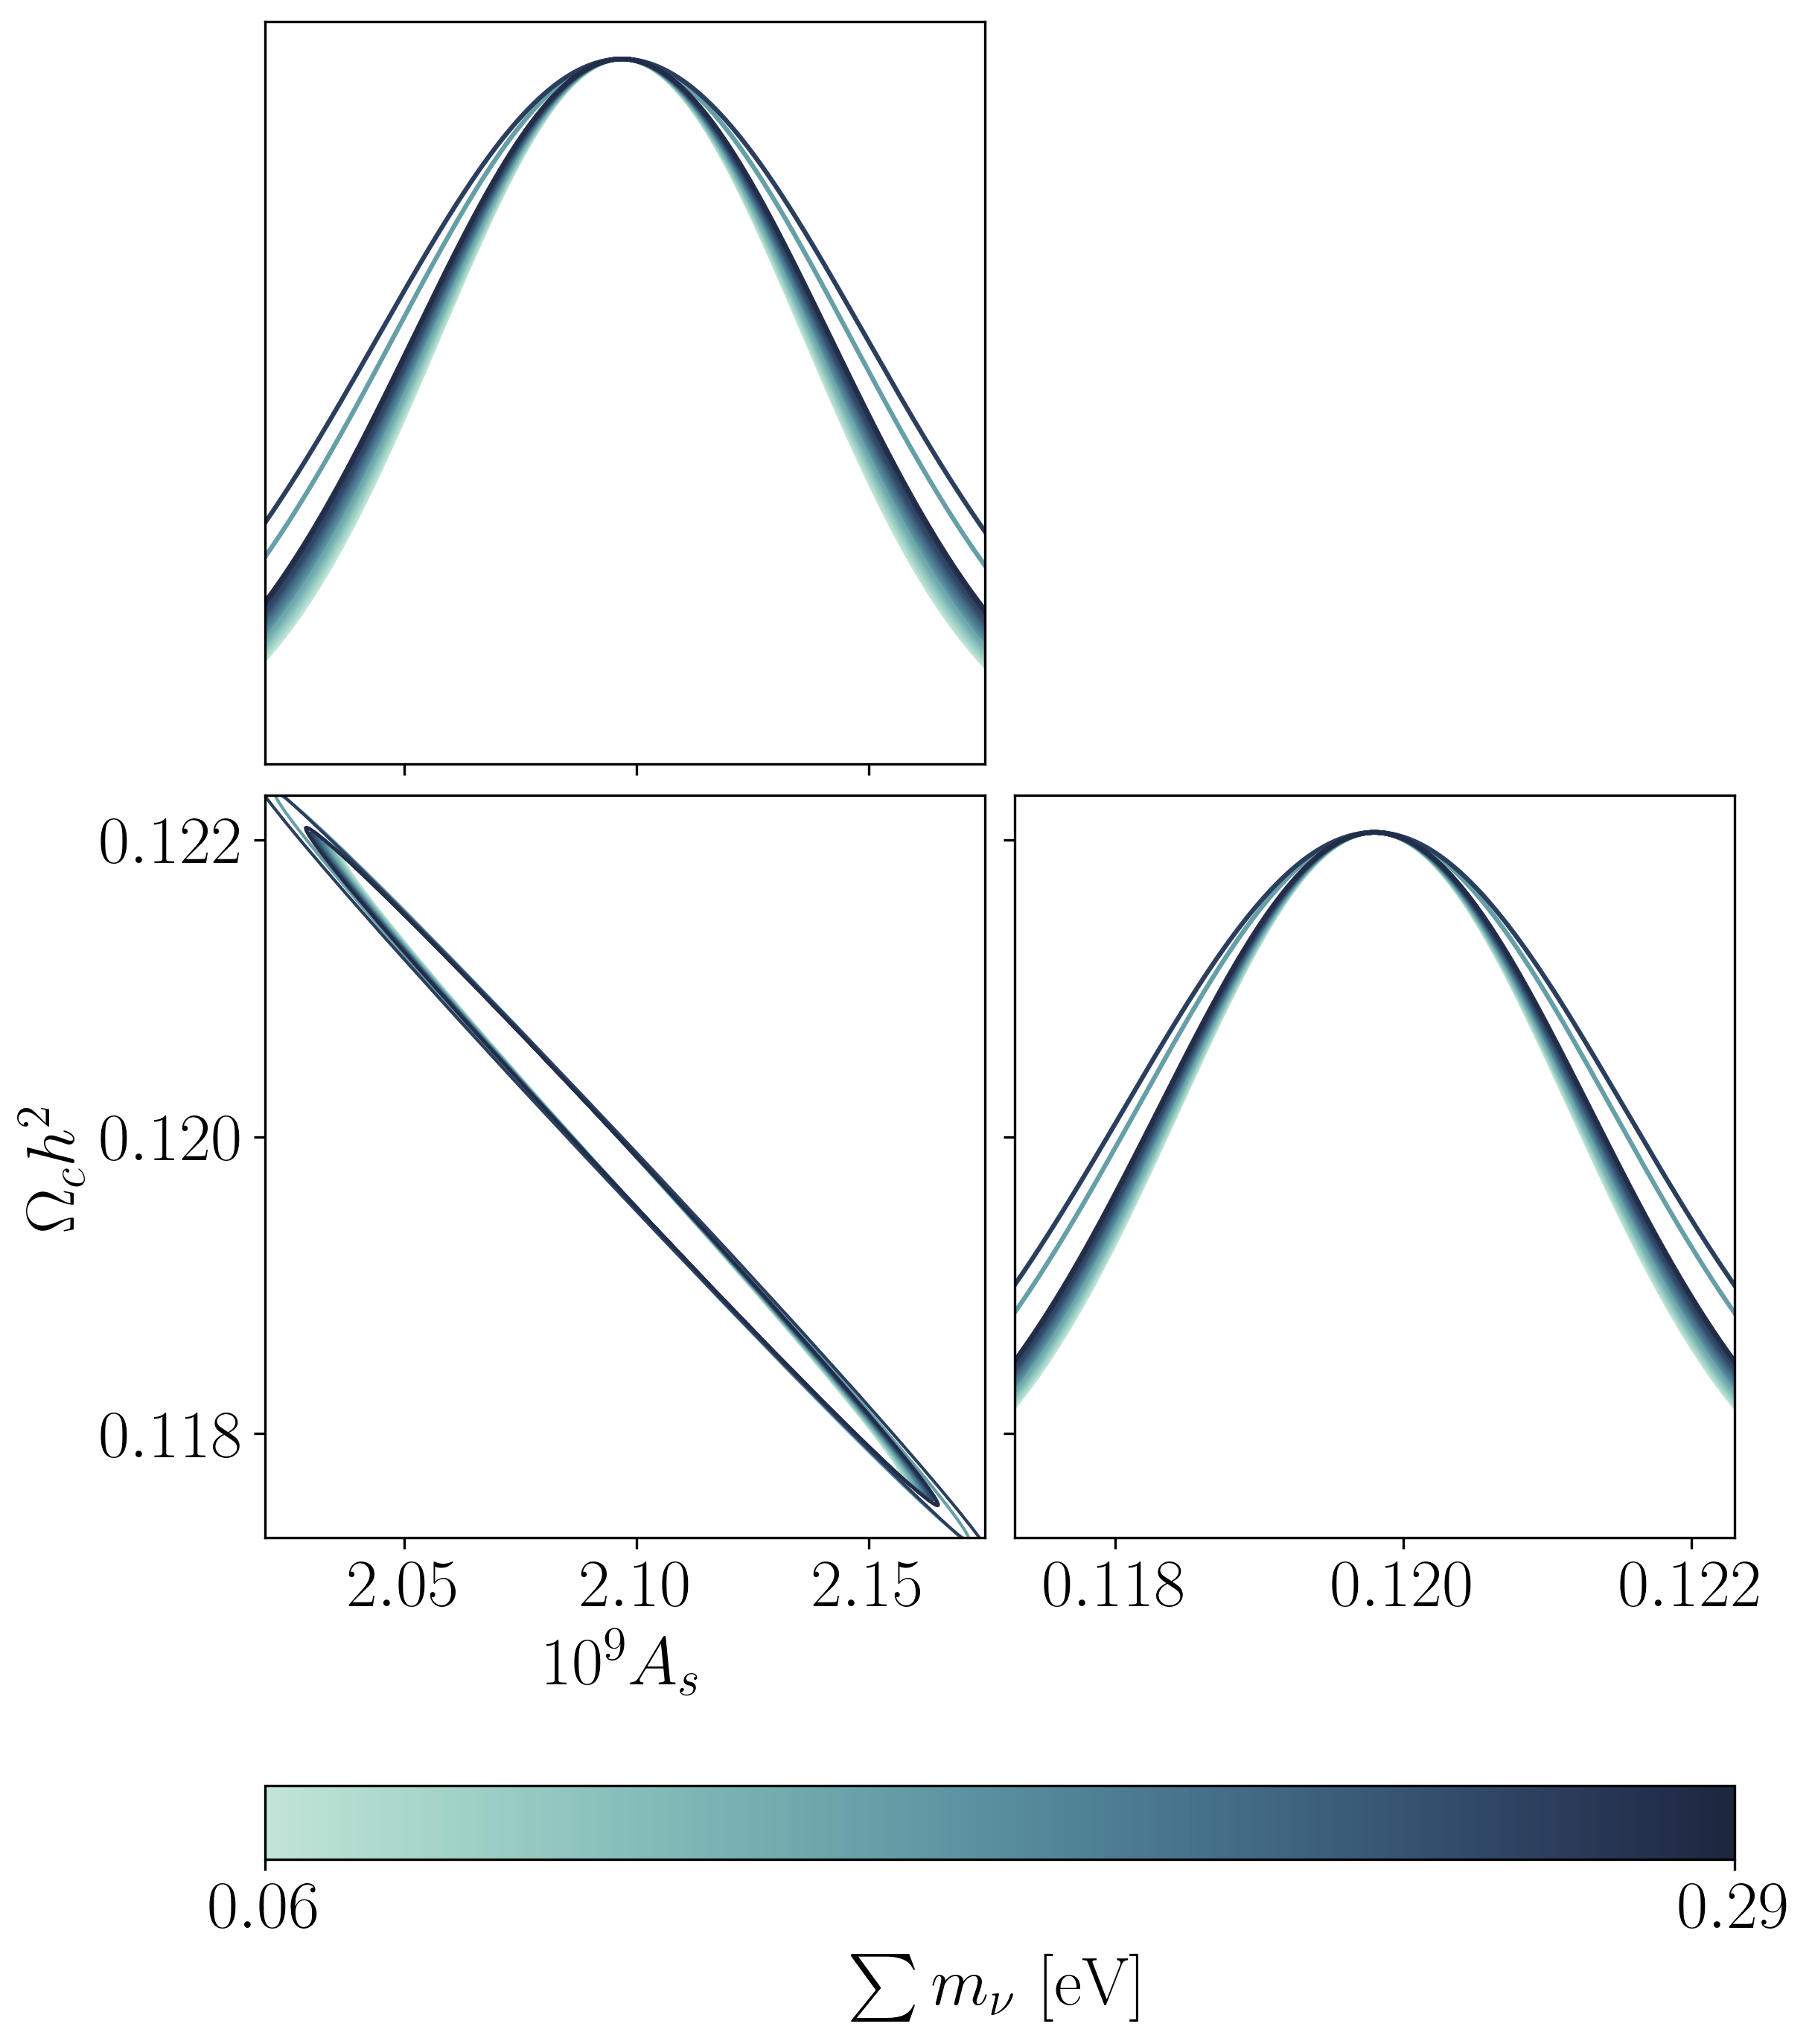

In [29]:
#https://arxiv.org/pdf/0906.4123.pdf
def ellipse_params(curr_cov):
    """Implements (2-4) of Coe's paper"""

    a2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          + np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    b2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          - np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    th = [[1/2*np.arctan(2*curr_cov[a][b]/(curr_cov[a][a] - curr_cov[b][b]))*180/np.pi 
           if a != b else -100
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    
    #fixes mixed up width and heights. 
    #a2[i][j] shouldn't equal a2[j][i] (the scales would be all wrong)
    #but should equal b2[j][i] since the width becomes the height
    #and vice versa. 
    for i in range(len(curr_cov)):
        for j in range(len(curr_cov)):
            if(curr_cov[i][i] < curr_cov[j][j]):
                a2[i][j], b2[i][j] = b2[i][j], a2[i][j]
    return(a2, b2, th)

from matplotlib.patches import Ellipse

fig, ax = plt.subplots(2,2, figsize=(8,9), dpi=300, sharex = 'col', sharey='row',constrained_layout=True)
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlim(2.02,2.175)
        ax[i][j].set_ylim(.1173,.1223)
ax[1,1].set_xlim(.1173,.1223)
import matplotlib.cm as cm

# Create a colormap
colormap = cm.rainbow

import seaborn as sns
colormap = sns.cubehelix_palette(as_cmap=True, start=1.5, light=1)
colormap = sns.cubehelix_palette(as_cmap=True, rot=-.3)

for color_idx,nu_mass in enumerate(nu_masses):
# for color_idx,nu_mass in enumerate([0.07, nu_masses[-1]]):
    cov = np.linalg.inv(fisher_matrixes[nu_mass])
    # Get a color from the colormap based on the index
    color = colormap(float(color_idx) / len(nu_masses))

    a2, b2, th = ellipse_params(cov)
#     print(nu_mass, cov[1,1])
    import matplotlib
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 22


    fid_As = fiducial_cosmology['10^9 As']
    fid_Omch2 = fiducial_cosmology['omch2']
    fid = [fid_As, fid_Omch2]
    #Table 1. of Coe
    alpha_1 = 1.52
    alpha_2 = 2.48
    alpha = np.array([alpha_1, alpha_2])
    labels = [r'$10^9A_s$', r'$\Omega_c h^2$',]

    #make cool elipses
    for i in range(len(cov)):
        for j in range(i):
            wdth = np.sqrt(a2[j][i])*alpha*2
            hght = np.sqrt(b2[j][i])*alpha*2

            sigma_1_ellipse = Ellipse(xy = (fid[j], fid[i]), 
                                        width= wdth[0],
                                        height= hght[0],
                                        angle=th[j][i], ls='-', 
                                        edgecolor=color, 
                                      lw=1, alpha=1,
                                        facecolor='none')
            ax[i][j].add_artist(sigma_1_ellipse)

#             sigma_2_ellipse = Ellipse(xy = (fid[j], fid[i]), 
#                                         width= wdth[1],
#                                         height= hght[1],
#                                         angle=th[j][i], ls='--', 
#                                         edgecolor=color, lw=1, alpha=0.1,
#                                         facecolor='none')
#             ax[i][j].add_artist(sigma_2_ellipse)        

            ax[j][i].axis('off')
            space = 2
            if(j==0):
                ax[i][j].set_ylabel(labels[i])
            if(i==len(cov)-1):
                ax[i][j].set_xlabel(labels[j])
    def gauss(mean, sig, x):
        return np.array([1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x0-mean)**2/(2*sig**2)) for x0 in x])

    #plot gaussians
    for i in range(len(cov)):
        
        sig = np.sqrt(cov[i][i])
        x = np.linspace(max(0, fid[i]-sig*5), fid[i] + sig*5, 10000)
        # we want to scale so that guassian fit in frame 
        # from what I understand the main thing we want to quantitatively 
        # preserve is the "spread" in x while the 
        # amplitude of the gaussian we can rescale 
        lower, upper = ax[i][i].get_ylim()
        scale = upper-lower
        y = gauss(fid[i], sig,x)
        y = lower + .95*scale/np.max(y) * y
#         ax[i][i].axvline(fid[i]-sig, ls='--', color=color)
#         ax[i][i].axvline(fid[i]+sig, ls='--', color=color)
        ax[i][i].plot(x, y, '-', color=color)
    
from matplotlib.colors import Normalize
norm = Normalize(vmin=min(nu_masses), vmax=max(nu_masses))
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', label=r'$\sum m_\nu$ [eV]')
cbar.set_ticks([min(nu_masses), max(nu_masses)])

ax[0][0].set_yticks([])
plt.savefig('As_omc_vs_Mnu.pdf', bbox_inches='tight')

In [ ]:
with open('cluster_abundance_fiducial_covariance.pkl', 'rb') as file:
    cluster_count_cov = pickle.load(file)
    
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]

                
                
from scipy.linalg import cho_factor, cho_solve
cholesky_factor = cho_factor(cov_matrix_2d)
cov_inv = cho_solve(cholesky_factor, np.eye(n_z * n_r))                
dμdθ = {}
dμdθ_unflat = {}

for parameter_changed in fiducial_log10_rel_step_size:
    cluster_abundance_pos = None
    cluster_abundance_neg = None
    log10_rel_step_size = fiducial_log10_rel_step_size[parameter_changed]
    fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.4f'%(parameter_changed, log10_rel_step_size)
    with open(fname_base, 'rb') as file:
        cluster_abundance_pos = pickle.load(file)
    with open(fname_base+'_neg', 'rb') as file:
        cluster_abundance_neg = pickle.load(file)
    h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
    tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
    flattened_theory_deriv = np.zeros((n_z * n_r))
    for i in range(n_z):
        for a in range(n_r):
            flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
    dμdθ[parameter_changed] = flattened_theory_deriv
    dμdθ_unflat[parameter_changed] = tmp_theory_deriv
n_parameters = len(fiducial_cosmology.keys())

fisher_matrix = np.zeros((n_parameters, n_parameters))

nu_mass_ev_idx = -1
for i, θi in enumerate(fiducial_cosmology.keys()):
    print(i, θi)
    if(θi == 'nu_mass_ev'):
        nu_mass_ev_idx = i
    for j, θj in enumerate(fiducial_cosmology.keys()):
        dμl_θi = dμdθ[θi]
        dμm_θj = dμdθ[θj]
        fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'

plt.imshow(np.log10(fisher_matrix), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'$\log_{10}$Fisher Matrix')
plt.show()
inv_fisher_matrix = np.linalg.inv(fisher_matrix)


marginalized = ['nu_mass_ev', 'ombh2', 'w0','H0','ns']
marginalized_idxs = [list(fiducial_cosmology.keys()).index(c) for c in marginalized]

for idx in reversed(sorted(marginalized_idxs)):
    inv_fisher_matrix = np.delete(inv_fisher_matrix, idx, axis=0)  
    inv_fisher_matrix = np.delete(inv_fisher_matrix, idx, axis=1) 
    
    
print('%10s\t %25s'%('parameter', 'fid val +/- σ(marginalized)'))
print('----------------------------------------------------------------------------')
i=0
for θi in (fiducial_cosmology.keys()):
    if(θi in marginalized):
        continue
    print('%10s\t %4.2f +/- %.3f'%(θi, (fiducial_cosmology[θi]),np.sqrt(inv_fisher_matrix[i,i])))
    i += 1

In [ ]:
#https://arxiv.org/pdf/0906.4123.pdf
def ellipse_params(curr_cov):
    """Implements (2-4) of Coe's paper"""

    a2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          + np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    b2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          - np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    th = [[1/2*np.arctan(2*curr_cov[a][b]/(curr_cov[a][a] - curr_cov[b][b]))*180/np.pi 
           if a != b else -100
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    
    #fixes mixed up width and heights. 
    #a2[i][j] shouldn't equal a2[j][i] (the scales would be all wrong)
    #but should equal b2[j][i] since the width becomes the height
    #and vice versa. 
    for i in range(len(curr_cov)):
        for j in range(len(curr_cov)):
            if(curr_cov[i][i] < curr_cov[j][j]):
                a2[i][j], b2[i][j] = b2[i][j], a2[i][j]
    return(a2, b2, th)

from matplotlib.patches import Ellipse

fig, ax = plt.subplots(2,2, figsize=(8,9), dpi=300, sharex = 'col', sharey='row',constrained_layout=True)
for i in range(2):
    for j in range(2):
        ax[i][j].set_xlim(-2,6)
        ax[i][j].set_ylim(0,0.4)
ax[1,1].set_xlim(0,0.4)
import matplotlib.cm as cm

# Create a colormap
colormap = cm.rainbow

import seaborn as sns
colormap = sns.cubehelix_palette(as_cmap=True, start=1.5, light=1)
colormap = sns.cubehelix_palette(as_cmap=True, rot=-.3)

def plot_ellipse(fig, ax, cov, color):
        

    a2, b2, th = ellipse_params(cov)
#     print(nu_mass, cov[1,1])
    import matplotlib
    matplotlib.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 22


    fid_As = fiducial_cosmology['10^9 As']
    fid_Omch2 = fiducial_cosmology['omch2']
    fid = [fid_As, fid_Omch2]
    #Table 1. of Coe
    alpha_1 = 1.52
    alpha_2 = 2.48
    alpha = np.array([alpha_1, alpha_2])
    labels = [r'$10^9A_s$', r'$\Omega_c h^2$',]

    #make cool elipses
    for i in range(len(cov)):
        for j in range(i):
            wdth = np.sqrt(a2[j][i])*alpha*2
            hght = np.sqrt(b2[j][i])*alpha*2

            sigma_1_ellipse = Ellipse(xy = (fid[j], fid[i]), 
                                        width= wdth[0],
                                        height= hght[0],
                                        angle=th[j][i], ls='-', 
                                        edgecolor=color, 
                                      lw=1, alpha=1,
                                        facecolor='none')
            ax[i][j].add_artist(sigma_1_ellipse)

#             sigma_2_ellipse = Ellipse(xy = (fid[j], fid[i]), 
#                                         width= wdth[1],
#                                         height= hght[1],
#                                         angle=th[j][i], ls='--', 
#                                         edgecolor=color, lw=1, alpha=0.1,
#                                         facecolor='none')
#             ax[i][j].add_artist(sigma_2_ellipse)        

            ax[j][i].axis('off')
            space = 2
            if(j==0):
                ax[i][j].set_ylabel(labels[i])
            if(i==len(cov)-1):
                ax[i][j].set_xlabel(labels[j])
    def gauss(mean, sig, x):
        return np.array([1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x0-mean)**2/(2*sig**2)) for x0 in x])

# for color_idx,nu_mass in enumerate(nu_masses):
for color_idx,nu_mass in enumerate([0.07, nu_masses[-1]]):
    cov = np.linalg.inv(fisher_matrixes[nu_mass])
    # Get a color from the colormap based on the index
    color = colormap(float(color_idx) / len(nu_masses))

    plot_ellipse(fig, ax, cov, color)
    #plot gaussians
    for i in range(len(cov)):
        
        sig = np.sqrt(cov[i][i])
        x = np.linspace(fid[i]-sig*5, fid[i] + sig*5, 10000)
        # we want to scale so that guassian fit in frame 
        # from what I understand the main thing we want to quantitatively 
        # preserve is the "spread" in x while the 
        # amplitude of the gaussian we can rescale 
        lower, upper = ax[i][i].get_ylim()
        scale = upper-lower
        y = gauss(fid[i], sig,x)
        y = lower + .95*scale/np.max(y) * y
#         ax[i][i].axvline(fid[i]-sig, ls='--', color=color)
#         ax[i][i].axvline(fid[i]+sig, ls='--', color=color)
        ax[i][i].plot(x, y, '-', color=color)
    
from matplotlib.colors import Normalize
norm = Normalize(vmin=min(nu_masses), vmax=max(nu_masses))
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', label=r'$\sum m_\nu$ [eV]')
cbar.set_ticks([min(nu_masses), max(nu_masses)])

ax[0][0].set_yticks([])

plot_ellipse(fig, ax, inv_fisher_matrix, 'black')
for i in range(len(inv_fisher_matrix)):
    sig = np.sqrt(inv_fisher_matrix[i][i])
    x = np.linspace(fid[i]-sig*5, fid[i] + sig*5, 10000)
    # we want to scale so that guassian fit in frame 
    # from what I understand the main thing we want to quantitatively 
    # preserve is the "spread" in x while the 
    # amplitude of the gaussian we can rescale 
    lower, upper = ax[i][i].get_ylim()
    scale = upper-lower
    y = gauss(fid[i], sig,x)
    y = lower + .95*scale/np.max(y) * y
#         ax[i][i].axvline(fid[i]-sig, ls='--', color=color)
#         ax[i][i].axvline(fid[i]+sig, ls='--', color=color)
    ax[i][i].plot(x, y, '-', color='black')

plt.savefig('As_omc_vs_Mnu_with_old_forecast.pdf', bbox_inches='tight')